In [1]:
import numpy as np
import matplotlib.pyplot as plt


from gyroscope import Solve_Gyro, Solve_Gyro_Free, Solve_Gyro_Forced_X
from gyroscope import Solve_Gyro_Forced_XY, Solve_Gyro_Forced_Y, Get_Gyro_Position
from gyroscope import Get_Gyro_Position_X

Precession frequency = 0.5234853107806692
Rotation frequency = 100.08808480281198
Gyros number (frequency) = 191.19559372841135
Gyros number (parameters) = 189.20686397844844
Gyros number gap = 1.0510875282988887 %
Larmor frequency =  0.5289875995947615  Hz


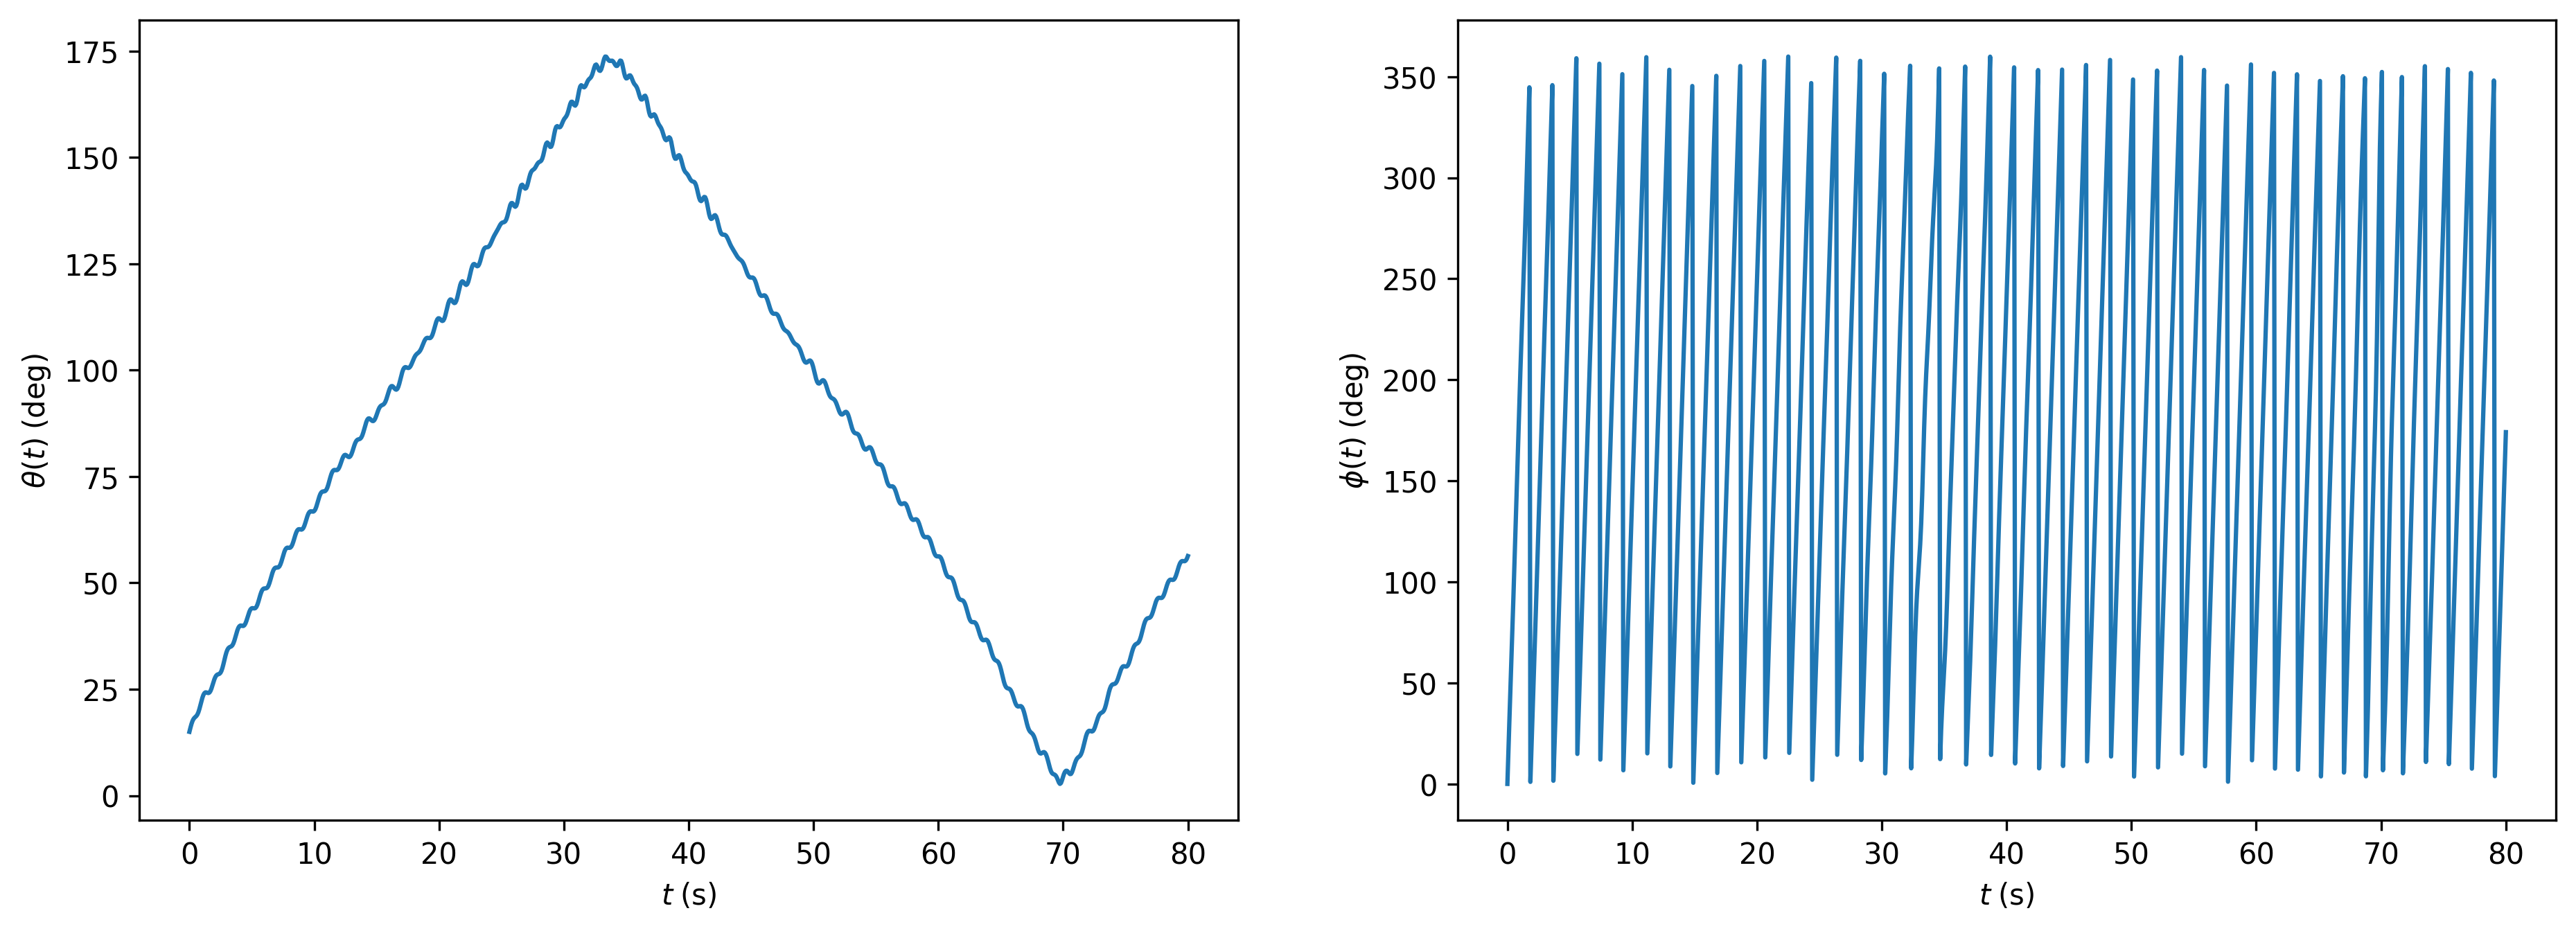

Precession frequency = 0.5416917771532545
Rotation frequency = 99.70390279916468
Gyros number (frequency) = 184.0602109988401
Gyros number (parameters) = 187.75713368474507
Gyros number gap = 1.9689918637724433 %
Larmor frequency =  0.5310259101343826  Hz


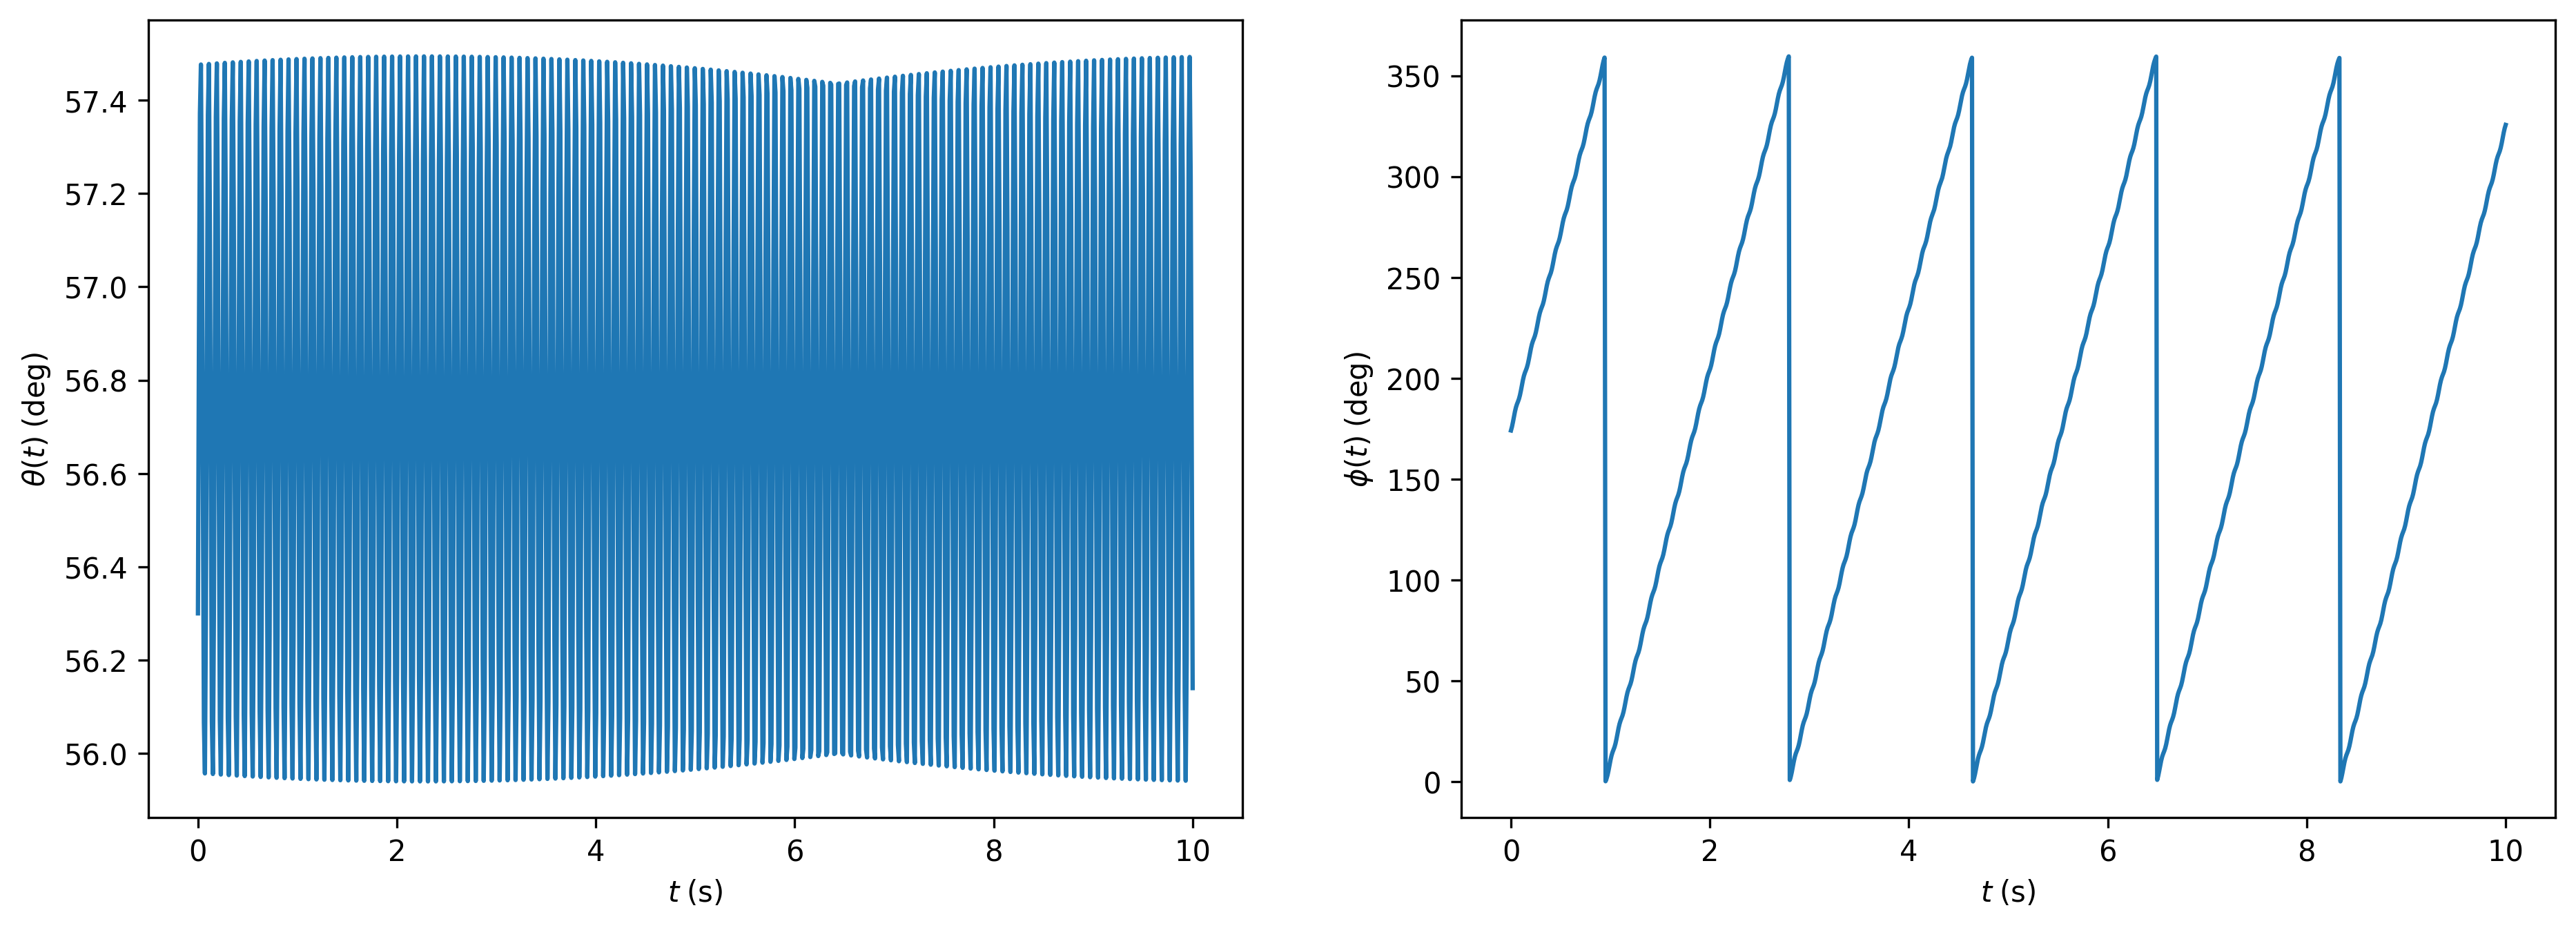

In [2]:
CI = [np.pi / 12, 0, 0, 0, 0, 2*np.pi*100]

t = np.linspace(0, 80, 1000)

g_ = 9.81
r = 53 / 2 * 1e-3
e = 12 * 1e-3
m_ = 0.375
#J3_ = m_ * (r**2) / 2
#J1_ = J3_ + m_ * e**2 / 12
J3_ = 0.000055
J1_ = 0.000055
h_ = 31.25 * 1e-3

x0_ = 5 * 1e-2
omega_f = 0.53
p_ = np.pi
params_f = [g_, m_, h_, J1_, J3_, x0_, p_, omega_f]

T, X, Y, Z, _, _, _ = Get_Gyro_Position_X(80, 10, CI, params_f, bool_plot=True)

#the_t, phi_t, phi_t, the_t_d, phi_t_d, psi_t_d, _, _, _, path = Solve_Gyro_Forced_XY(t, CI, params_f)

#print(np.max(the_t * 180 / np.pi))

#path

In [5]:
def balayage_frequences(f1, f2, pas):
    return np.arange(f1, f2 + pas, pas)

def Rabi_Chevron_omega(f1, f2, pas, params, tf=80, time_len = 1000, CI = [np.pi / 12, 0, 0, 0, 0, 2*np.pi*100], plot=True):
    
    omega = balayage_frequences(f1, f2, pas)
    time = np.linspace(0, tf, time_len, endpoint=True)
    tab_theta = []
    for w in omega:
        params[-1] = w
        theta, _, _, _, _, _, _, _, _, _ = Solve_Gyro(time, CI, params, forcing="X", plot=False, numbers=False)
        tab_theta.append(np.max(theta) * 180 / np.pi)
    
    tab_theta = np.array(tab_theta)

    plt.figure()
    plt.plot(omega, tab_theta)
    plt.xlabel(r"$f \; (\mathrm{Hz})$")
    plt.ylabel(r"$\theta_\mathrm{max} \; (\mathrm{deg})$")
    
    return omega, tab_theta

    

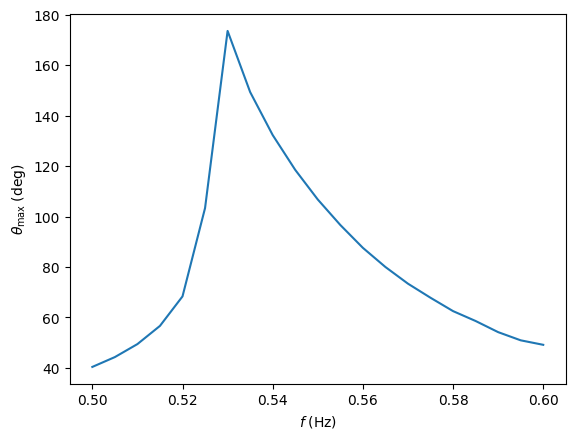

In [18]:
params = params_f

A, B = Rabi_Chevron_omega(0.5, 0.6, 0.005, params)

In [19]:
from scipy.optimize import curve_fit

[ 1.34249005e+02 -3.05352894e-02  5.41112250e-01]
[9.50359065e+00 3.69211969e-03 2.14820010e-03]


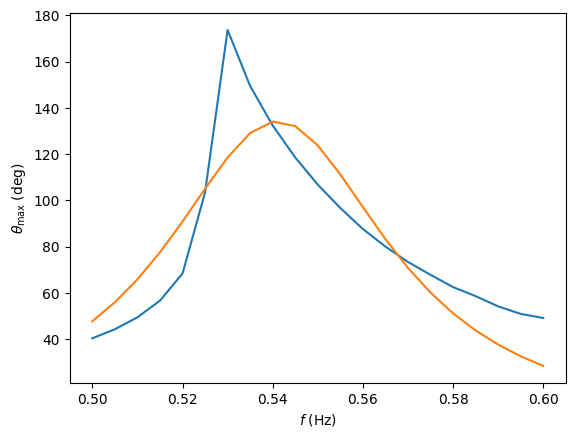

In [20]:
A0 = A[B == np.max(B)]

def fit_lorentz(x, coeff, largeur, a0):
    return coeff / (1 + ((x - a0) / largeur)**2)

tab, pcov = curve_fit(fit_lorentz, A, B, p0 = [np.max(A), 0.5, 80])
print(tab)
print(np.sqrt(np.diag(pcov)))

plt.figure()
plt.plot(A, B)
plt.xlabel(r"$f \; (\mathrm{Hz})$")
plt.ylabel(r"$\theta_\mathrm{max} \; (\mathrm{deg})$")
plt.plot(A, fit_lorentz(A, *tab))
plt.show()

[-1.00267197e+01  1.20292688e+08]
[2.90724945e-01 6.25167276e+07]


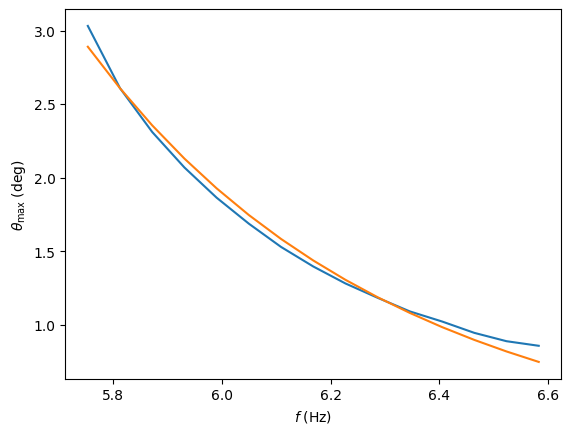

In [21]:
A_fit = A[A >= A[B == np.max(B)]] * 2 * np.pi / A0
B_fit = B[A >= A[B == np.max(B)]] * np.pi / 180

plt.figure()
plt.plot(A_fit - A0, B_fit)
plt.xlabel(r"$f \; (\mathrm{Hz})$")
plt.ylabel(r"$\theta_\mathrm{max} \; (\mathrm{deg})$")

from scipy.optimize import curve_fit

def fit_puissance(x, a, b):
    return b * (x**a)

tab, pcov = curve_fit(fit_puissance, A_fit - A0, B_fit)
print(tab)

print(np.sqrt(np.diag(pcov)))

plt.plot(A_fit - A0, fit_puissance(A_fit - A0 ,*tab))
plt.show()

In [26]:
def balayage_frequences(f1, f2, pas):
    return np.arange(f1, f2 + pas, pas)

def balayage_amplitudes(x1, x2, pas):
    return np.arange(x1, x2 + pas, pas)

def Rabi_Chevron(f1, f2, pas_f, x1, x2, pas_x, params, tf=100, time_len = 1000, CI = [np.pi / 12, 0, 0, 0, 0, 2*np.pi*100], plot=True):
    
    tab_omega = balayage_frequences(f1, f2, pas_f)
    tab_x = balayage_amplitudes(x1, x2, pas_x) * 1e-2
    time = np.linspace(0, tf, time_len, endpoint=True)
    tab_theta = np.zeros((len(tab_x), len(tab_omega)))

    
    for i in range(len(tab_x)):
        params[-3] = tab_x[i]
        for j in range(len(tab_omega)):
            params[-1] = tab_omega[j]
            theta, _, _, _, _, _, _, _, _, _ = Solve_Gyro(time, CI, params, forcing="X", plot=False, numbers=False)
            tab_theta[i, j] = np.max(theta)
    tab_theta = tab_theta * 180 / np.pi
    
    if plot:
        print("Yadra...")
    
    return tab_omega, tab_x, tab_theta

    

In [42]:
w_test, x_test, theta_2d_test = Rabi_Chevron(0.52, 0.56, 0.0005, 2, 10, 1, params)

/Users/bradaizakaria/Documents/venvL3/envL3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



KeyboardInterrupt: 

In [ ]:
plt.imshow(theta_2d_test)
plt.colorbar()

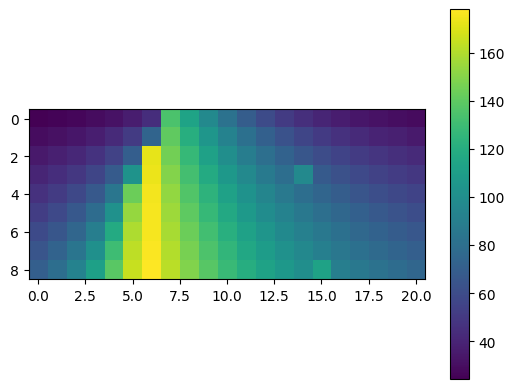

In [29]:
plt.imshow(theta_2d_test)
plt.colorbar()

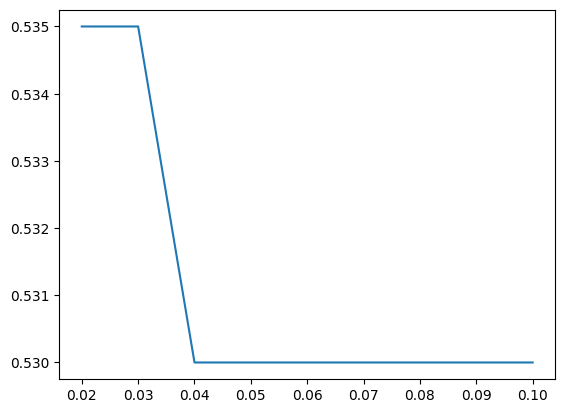

In [41]:
tab_omega_MAX = []
for i in range(theta_2d_test.shape[0]):
    tab_omega_MAX.append(w_test[theta_2d_test[i,:]==np.max(theta_2d_test[i,:])])

tab_omega_MAX = np.array(tab_omega_MAX)

plt.figure()
plt.plot(x_test, tab_omega_MAX)

In [32]:
theta_2d_test.shape[0]

9

In [3]:
%matplotlib qt

In [4]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.animation import FuncAnimation, FFMpegWriter

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set(xlim3d=(-1.2, 1.2), xlabel='X')
ax.set(ylim3d=(-1.2, 1.2), ylabel='Y')
ax.set(zlim3d=(-1.2, 1.2), zlabel='Z')
# Tracé initial du point et de la ligne
point, = ax.plot([X[0]], [Y[0]], [Z[0]], 'b.')
line, = ax.plot(X[:1], Y[:1], Z[:1], color='b')

point_static, = ax.plot(0, 0, 0, 'k.')

# Ajouter une flèche
#arrow = FancyArrowPatch((0, 0, 0), (X[0], Y[0], Z[0]), mutation_scale=15, color='blue')
#ax.add_patch(arrow)




# Initialiser la flèche
arrow = ax.quiver(0, 0, 0, 0, 0, 0, color='red', arrow_length_ratio=0.01)

text_time = ax.text2D(0.02, 0.95, '', transform=ax.transAxes, color='black')

text_CI = ax.text2D(0.02, 1, r'$\theta_0 =$' + str(round(CI[0] * 180 / np.pi, 0)) + r'$^\circ$', transform=ax.transAxes, color='black')
text_CI_omega = ax.text2D(0.02, 0.9, r'$f_{\psi} =$' + str(round(CI[-1] / (2 * np.pi), 0)) + '$\;\mathrm{Hz}$', transform=ax.transAxes, color='black')


# Fonction de mise à jour pour l'animation
def update(num, X, Y, Z, point, line, point_static, arrow):
    point.set_data(X[num-1:num], Y[num-1:num])
    point.set_3d_properties(Z[num-1:num])

    line.set_data(X[:num], Y[:num])
    line.set_3d_properties(Z[:num])

    # Mettre à jour la position de la flèche
    arrow.set_segments([[[0, 0, 0], [X[num], Y[num], Z[num]]]])

    text_time.set_text(f'Time: {T[num]:.2f} s')


    return point, line, point_static, arrow

# Augmenter la fréquence de trame pour accélérer l'animation
frame_rate = 100000000
num_frames = len(T)
interval = 0.00001 # 1000 / frame_rate

# Animer le tracé
ani = FuncAnimation(fig, update, frames=num_frames, interval=interval,
                    fargs=(X, Y, Z, point, line, point_static, arrow), blit=False)

# Enregistrer l'animation en tant que fichier vidéo avec Pillow
#ani.save('animation_3d_with_arrow.gif', writer=PillowWriter(fps=frame_rate))

#ani.save('animation_XY_RotatingRef.mp4', writer=FFMpegWriter(fps=frame_rate))



# Afficher le graphique interactif
plt.show()
